In [1]:
import torch 
import random
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field

import sys
sys.path.append("..")

from model import Forecaster, plot_forecast
from configs import PatchFMConfig
from dataset import UTSDataset

In [2]:
@dataclass
class NotebookConfig:
  context_size: int = 1024 # the length of the context signal
  forecast_horizon: int = 64 # the length of the forecast horizon
  quantiles: list[float] = field(default_factory=lambda: [0.1, 0.5, 0.9]) # the quantiles to be predicted (0.5 is the forecast)

  context_plot_limit: int = 300 # not show the whole context but last 'context_plot_limit' observations (just for visualization)

config_nb = NotebookConfig()

In [4]:
# --- Instantiate model ---
config = PatchFMConfig(compile=True, load_from_hub=True)
model = Forecaster(config)

Loading base model from HuggingFace Hub...


config.json:   0%|          | 0.00/264 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.28G [00:00<?, ?B/s]

# Forecasting

In [5]:
# --- Load UTSD dataset ---
dataset = UTSDataset(input_len=config_nb.context_size, output_len=config_nb.forecast_horizon, flag="val")

Resolving data files:   0%|          | 0/320 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/80 [00:00<?, ?it/s]

Indexing dataset...


100%|██████████| 68679/68679 [00:26<00:00, 2570.36it/s]


Context shape: torch.Size([1, 1024]), Target shape: torch.Size([64])


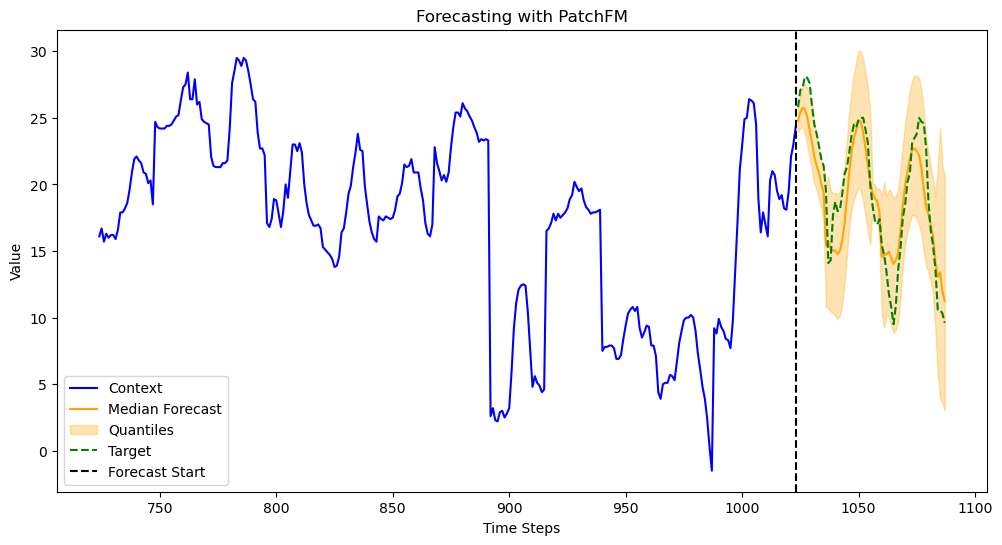

In [21]:
idx = random.randint(0, len(dataset))
context, target = dataset[idx]
xx = torch.cat([context, target], dim=0)

context = xx[:config_nb.context_size].unsqueeze(0)
target = xx[config_nb.context_size:config_nb.forecast_horizon + config_nb.context_size]

print(f"Context shape: {context.shape}, Target shape: {target.shape}")

pred_median, pred_quantiles = model(context, forecast_horizon=config_nb.forecast_horizon, quantiles=config_nb.quantiles)

plot_forecast(context, pred_median, pred_quantiles, target_pred=target, context_plot_limit=config_nb.context_plot_limit)